In [2]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(picante)
library(car)
library(dunn.test)
library(ggpubr)

### Pre-processing

In [104]:
#CREATE PHYLOSEQ OBJECT

biom <- import_biom("~/Data/data.biom")
map <- import_qiime_sample_data("~/Data/metadata.txt")
tree <- read_tree("~/Data/phylo.tre")
batrun_nt <- merge_phyloseq(biom,tree,map)
batrun_nt <- prune_samples((sample_sums(batrun_nt) > 1000), batrun_nt)

#CHANGE TAXA COLUMN NAMES FROM (E.G. FROM"RANK" TO "KINGDOM")
colnames(tax_table(batrun_nt)) <- c("kingdom", "phylum", "class", "order", "family",  "genus", "species")

Warning message in strsplit(msg, "\n"):
“input string 1 is invalid in this locale”

#### Summarize sequencing depth by sample type

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


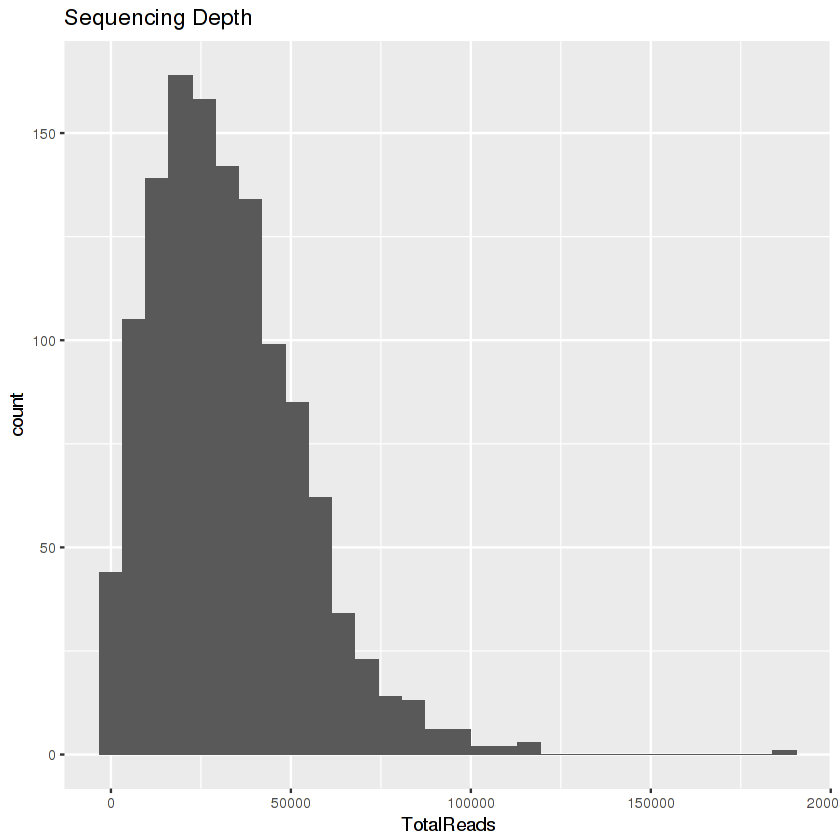

In [110]:
batrun_sdt = data.table(as(sample_data(batrun_nt), "data.frame"),
                 TotalReads = sample_sums(batrun_nt), keep.rownames = TRUE)
setnames(batrun_sdt, "rn", "SampleName")
pSeqDepth = ggplot(batrun_sdt, aes(TotalReads)) + geom_histogram() + ggtitle("Sequencing Depth")
pSeqDepth

In [111]:
batrun.summary = batrun_sdt %>%
    group_by(SampleType) %>%
summarise(avg = mean(TotalReads), 
              sd = sd(TotalReads), 
              sem = sd/sqrt(length(TotalReads))) %>%
    arrange((SampleType))
batrun.summary[complete.cases(batrun.summary),]

SampleType,avg,sd,sem
FecalFTA,41963.77,21697.85,1082.1905
TongueEtOH,28650.17,22365.17,1153.3956
SkinEtOH,26992.98,15483.25,723.4847


### Alpha diversity

#### Estimate Shannon diversity index

In [107]:
#sample_tab = read.csv("~/Data/metadata.csv")
sample_tab = read.csv("/group/gilbert-lab/Lutz/Batmicrobiome/batrun_finaldata_for_phyloseq_Oct2017/Metadata_files/FinalMappingFile_noswabs.csv")
colnames(sample_tab)[1] <- "SampleID"


In [108]:
#ESTIMATE SHANNON DIVERSITY
sha = estimate_richness(batrun_nt, split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)

dfsha = merge(sha, sample_tab, on="SampleID")

ordsha = sha %>% group_by("SampleType") %>%
    summarize(med.sha = median(Shannon)) %>%
    arrange(desc(med.sha)) %>%
    magrittr::extract2("SampleType")

stats = dfsha %>%
    group_by(SampleType) %>%
    summarize(median = median(Shannon), 
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) %>%
    arrange(-desc(SampleType))
stats

SampleType,median,mean,sd,sem
FecalFTA,1.411972,1.524695,0.8681219,0.04181596
SkinEtOH,4.563169,4.423806,0.9183671,0.04263412
TongueEtOH,1.395439,1.463988,0.9202091,0.04647758



	Kruskal-Wallis rank sum test

data:  Shannon by SampleType
Kruskal-Wallis chi-squared = 796.02, df = 2, p-value < 2.2e-16


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 796.0165, df = 2, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |   FecalFTA   SkinEtOH
---------+----------------------
SkinEtOH |  -24.09624
         |    0.0000*
         |
TongueEt |   0.761793   24.27289
         |     0.6693    0.0000*

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 796.0165

$Z
[1] -24.0962459   0.7617935  24.2728997

$P
[1] 1.368411e-128  2.230916e-01 1.895047e-130

$P.adjusted
[1] 4.105233e-128  6.692749e-01 5.685142e-130

$comparisons
[1] "FecalFTA - SkinEtOH"   "FecalFTA - TongueEtOH" "SkinEtOH - TongueEtOH"

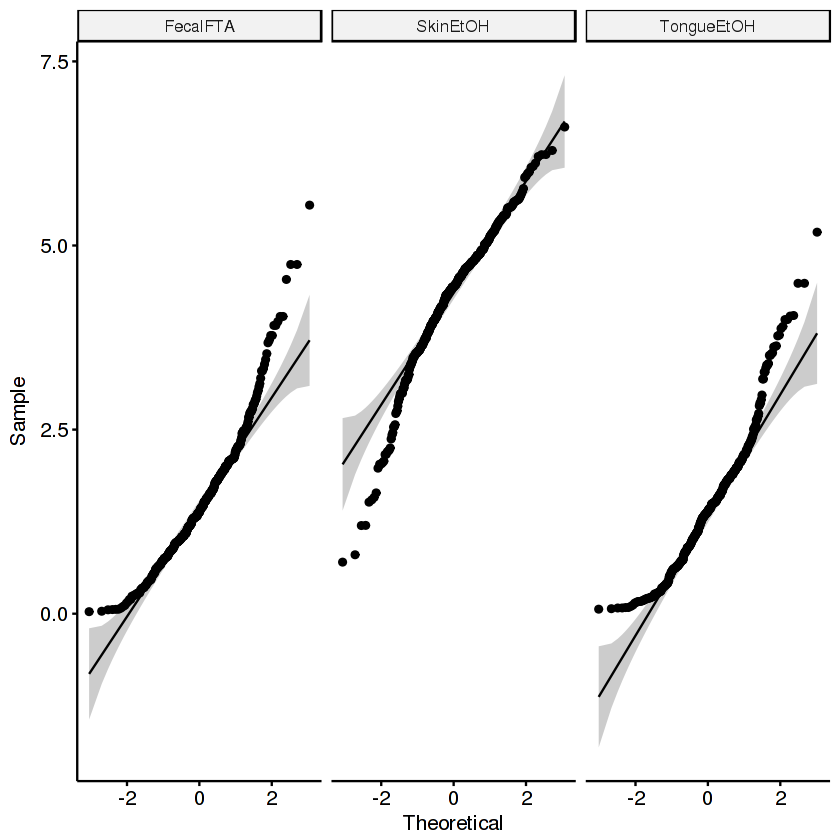

In [91]:
#CHECK FOR NORMAL/NON-NORMAL DISTRIBUTION
p = ggqqplot(dfsha, x = "Shannon")
p = p + facet_wrap("SampleType")
p

#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Shannon~SampleType, data=dfsha)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfsha$Shannon, g=dfsha$SampleType, method="bonferroni")
dunn

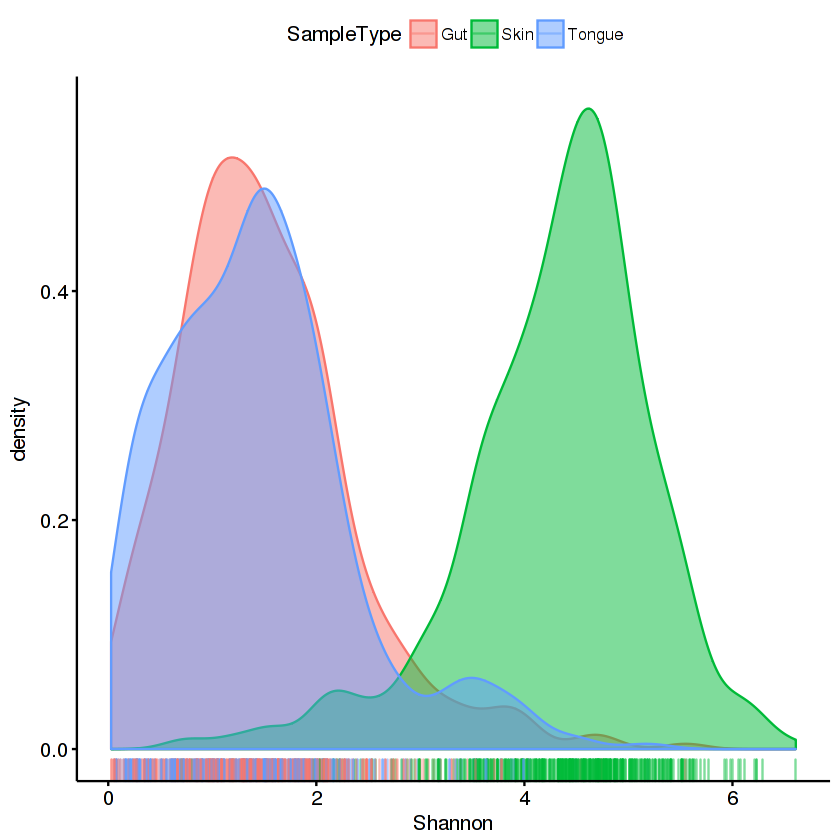

In [95]:
#PLOT (DENSITY PLOT) SHANNON DIVERSITY BY SAMPLE TYPE
dfsha$SampleType <- factor(
     dfsha$SampleType, 
     labels=c('Gut','Skin', 'Tongue'))
p2 = ggdensity(dfsha, x = "Shannon", color = "SampleType", fill= "SampleType", rug=TRUE)
p2

#### Estimate Observed ESV richness

In [ ]:
sample_tab = read.csv("~/Data/metadata.csv")

In [96]:
#ESTIMATE OBSERVED ESV RICHNESS
obs = estimate_richness(batrun_nt, split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)

dfobs = merge(obs, sample_tab, on="SampleID")

ordobs = obs %>% group_by("SampleType") %>%
    summarize(med.obs = median(Observed)) %>%
    arrange(desc(med.obs)) %>%
    magrittr::extract2("SampleType")

stats = dfobs %>%
    group_by(SampleType) %>%
    summarize(median = median(Observed), 
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) %>%
    arrange(-desc(SampleType))
stats

SampleType,median,mean,sd,sem
FecalFTA,49,68.80510,68.71589,3.309928
SkinEtOH,413,553.16164,388.47839,18.034657
TongueEtOH,50,77.91837,92.12656,4.653094



	Kruskal-Wallis rank sum test

data:  Observed by SampleType
Kruskal-Wallis chi-squared = 780.3, df = 2, p-value < 2.2e-16


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 780.2963, df = 2, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |   FecalFTA   SkinEtOH
---------+----------------------
SkinEtOH |  -24.10057
         |    0.0000*
         |
TongueEt |   0.279667   23.78661
         |     1.0000    0.0000*

alpha = 0.05
Reject Ho if p <= alpha/2


$chi2
[1] 780.2963

$Z
[1] -24.1005721   0.2796672  23.7866125

$P
[1] 1.232712e-128  3.898664e-01 2.297562e-125

$P.adjusted
[1] 3.698135e-128  1.000000e+00 6.892685e-125

$comparisons
[1] "FecalFTA - SkinEtOH"   "FecalFTA - TongueEtOH" "SkinEtOH - TongueEtOH"

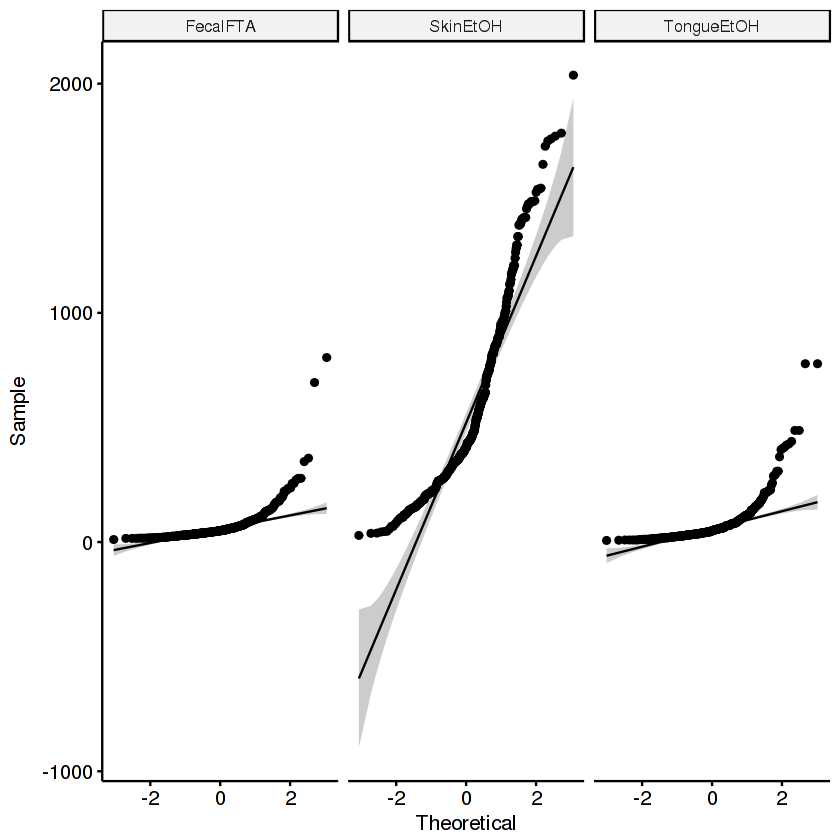

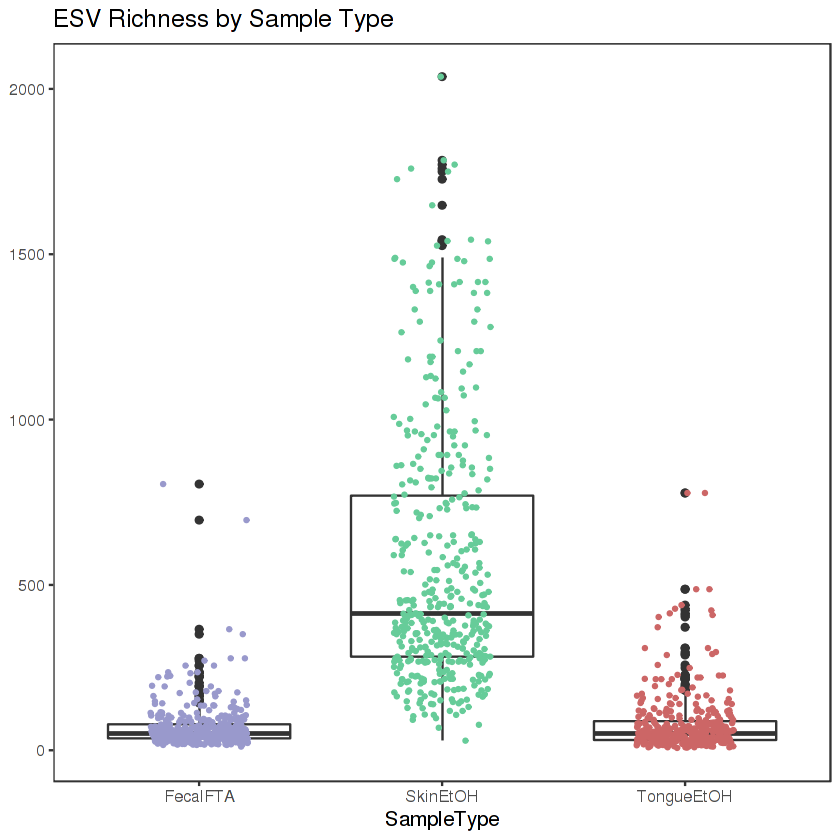

In [98]:
#CHECK FOR NORMAL/NON-NORMAL DISTRIBUTION
p3 = ggqqplot(dfobs, x = "Observed")
p3 = p3 + facet_wrap("SampleType")
p3

#CHECK FOR SIGNIFICANCE
stats.krusk = kruskal.test(Observed~SampleType, data=dfobs)
stats.krusk

#POST-HOC ANALYSIS
dunn = dunn.test(dfobs$Observed, g=dfobs$SampleType, method="bonferroni")
dunn

#PLOT (BOXPLOT) OBSERVED ESV RICHNESS BY SAMPLE TYPE
p4 = ggplot(na.omit(dfobs), aes(x = SampleType, y = Observed)) + 
        ggtitle("ESV Richness by Sample Type")

p4 = p4 + geom_boxplot() + ylab("Observed ESVs")

p4 = p4 + geom_point(size = .75, aes(color = SampleType),  
                   position = position_jitter(h = 0, w = 0.2))

p4 = p4 + scale_color_manual(values=c("#9999CC","#66CC99","#CC6666"))

p4 = p4 + theme_bw() + theme(text=element_text(size=12, color="black",family="Arial"),
                           legend.key = element_blank(),
                           legend.position = "none",
                           axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
p4

#### Examine ESV richness by elevation

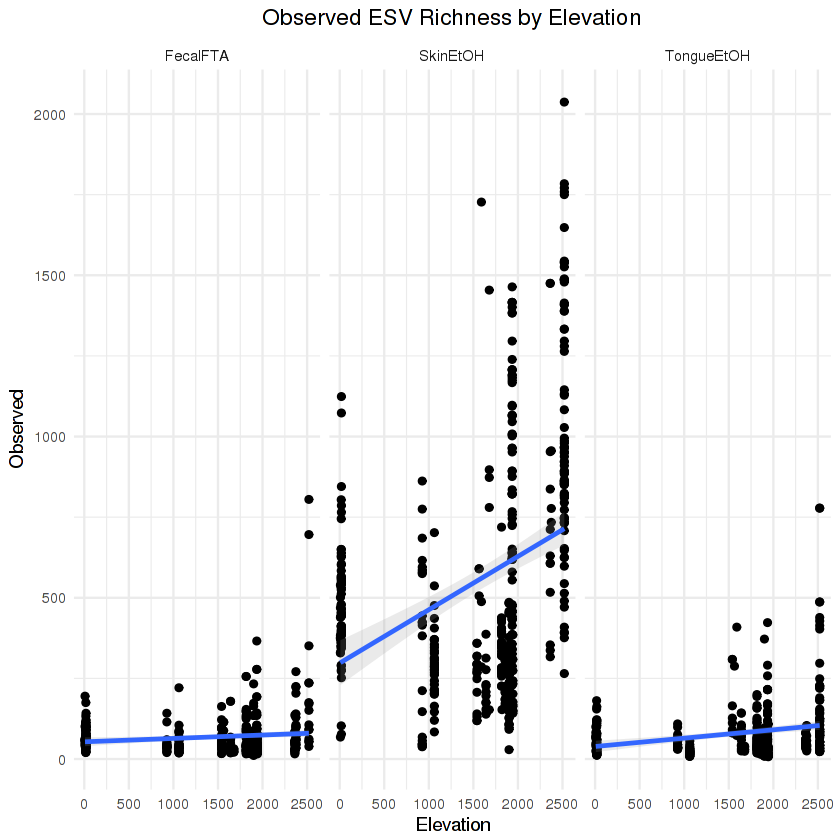

In [99]:
#PLOT ESV RICHNESS BY ELEVATION
p5 = ggplot(dfobs, aes(x=Elevation, y=Observed)) + geom_point() + 
        ggtitle("Observed ESV Richness by Elevation")
p5 = p5 + geom_smooth(method = "lm", se=TRUE, alpha=.2)
p5 = p5 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p5 = p5 + facet_wrap(~SampleType)
p5

In [101]:
#SUMMARIZE REGRESSION COEFFICIENTS - Break down by sample type before running
fit <- lm(Elevation ~ Observed, data = <data>)
summary(fit)

### Beta diversity

#### Transform data

In [ ]:

batrun <- prune_samples((sampleSums(batrun_nt) > 1000), batrun_nt) %>%
    transform_sample_counts(function(x) x / sum(x))

#### Subset transformed data by sample type (for beta diversity metrics)

In [ ]:
#GUT
batrun_gut = subset_samples(batrun, SampleType=="FecalFTA")
batrun_gut = prune_taxa(taxa_sums(batrun_gut)>0, batrun_gut)
#ORAL
batrun_oral = subset_samples(batrun, SampleType=="TongueEtOH")
batrun_oral = prune_taxa(taxa_sums(batrun_oral)>0, batrun_oral)
#SKIN
batrun_skin = subset_samples(batrun, SampleType=="SkinEtOH")
batrun_skin = prune_taxa(taxa_sums(batrun_skin)>0, batrun_skin)

#### Calculate beta diversity based on various distance metrics

In [ ]:
# WEIGHTED UNIFRAC
batgut.dist.wunif = distance(batrun_gut, method = "wunifrac", type = "samples")
batoral.dist.wunif = distance(batrun_oral, method = "wunifrac", type = "samples")
batskin.dist.wunif = distance(batrun_skin, method = "wunifrac", type = "samples")

# UNWEIGHTED UNIFRAC
batgut.dist.unif = distance(batrun_gut, method = "unifrac", type = "samples")
batoral.dist.unif = distance(batrun_oral, method = "unifrac", type = "samples")
batskin.dist.unif = distance(batrun_skin, method = "unifrac", type = "samples")

# BRAY-CURTIS
batgut.dist.bc = distance(batrun_gut, method = "bray", type = "samples")
batoral.dist.bc = distance(batrun_oral, method = "bray", type = "samples")
batskin.dist.bc = distance(batrun_skin, method = "bray", type = "samples")

#### Perform ADONIS test(s) to check for significance of variables

In [ ]:
#GUT
batgut.wunif.adtest = adonis2(batgut.dist.wunif ~ Host_Genus/Host_species + Ecto_status + Haem_status, strata= Locality, by = "margin", data=batgut.df)
batgut.wunif.adtest
#ORAL
batoral.wunif.adtest = adonis2(batoral.dist.wunif ~ Host_Genus/Host_species + Ecto_status + Haem_status, strata= Locality, by = "margin", data=batoral.df)
batoral.wunif.adtest
#SKIN
batskin.wunif.adtest = adonis2(batskin.dist.wunif ~ Host_Genus/Host_species + Ecto_status + Haem_status, strata= Locality, by = "margin", data=batskin.df)
batskin.wunif.adtest

#### Create PCoA plots

In [ ]:
#E.G. CREATE PCOA PLOT FOR GUT MICROBIOME / WEIGHTED UNIFRAC
batgut.wunif.log = ordinate(batrun_gut, method = "PCoA", distance = "wunifrac")
batgut.wunif.evals = batgut.wunif.log$values$Eigenvalues
batgut.wunif.pcoa = plot_ordination(batsall_.00, batsall.00.wunif.log, color = "Locality") + ggtitle("Bat Gut Microbiome - Weighted Unifrac PCoA") + geom_point(size=2) + coord_fixed(sqrt(batgut.wunif.evals[2] / batgut.wunif.evals[1]))
batgut.wunif.pcoa